In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import scipy.fftpack
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.signal import chirp, find_peaks, peak_widths
!pip install xlrd==1.2.0

In [2]:
#reading in data from excel files

data = pd.read_excel('helium_data.xlsx', sheet_name = 'he_100') 

[]

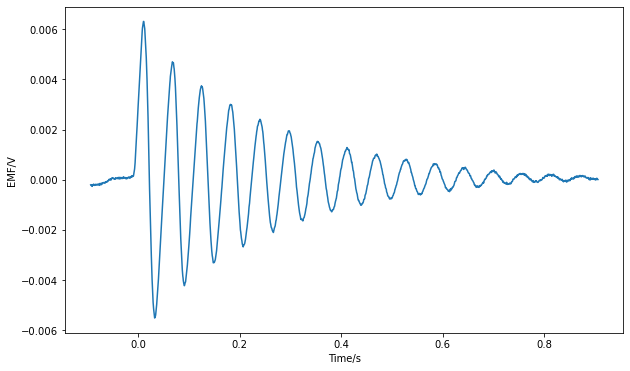

In [3]:
# allocating data to variables, not including the first 54 data points in the file
voltage=data['V (V)']
time=data['t(s)']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(time, voltage)
plt.xlabel("Time/s")
plt.ylabel("EMF/V")
plt.plot()

In [4]:
#cleaning up the data, so only taking data points between t=0 and the cut off point, so where it starts to get noisy
#Cut off point is own personal choice
t_cutoff = float(input("The time at which the data becomes too noisy is: "))

The time at which the data becomes too noisy is: 0.7


[]

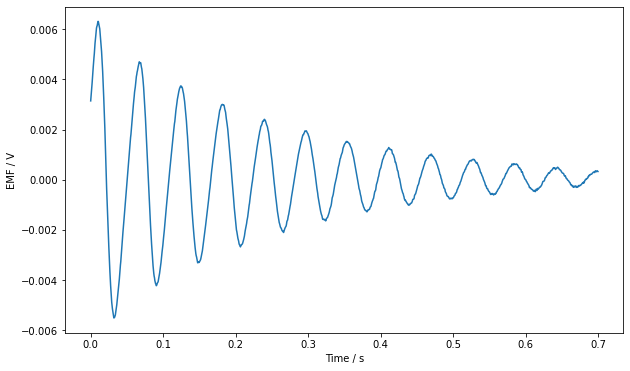

In [5]:
#Now editing the data so we only consider data within the chosen limits

refined_time = []
refined_voltage =[]



for i in range(0, len(time)):
    if time[i] >=0 and time[i] <= t_cutoff:
        refined_time.append(time[i])
        refined_voltage.append(voltage[i])

#Now plotting the emf vs time again just for clarity

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(refined_time, refined_voltage)
plt.xlabel("Time / s")
plt.ylabel("EMF / V")
plt.plot()

In [6]:
#Now we begin to fit a SHM curve to the data
#This fits a curve in the form of x(t), however will later need to be modified to v(t) for a better fit

def f(x,a,b,c,d):
    return ((a*np.exp(b*x))*np.cos(c*x+d))

a= -0.0060

b= -4.0314

c= 109.0653

d= 2.2981



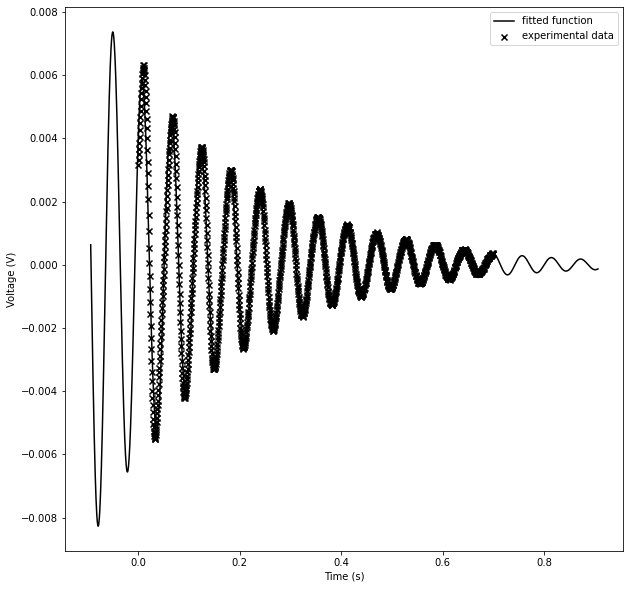

In [7]:
#calculating the optimal parameters for the SHM fit

popt, pcov = curve_fit(f, refined_time, refined_voltage, p0=[0.4, -1, 100,2])
print('a= %.4f\n' %popt[0])
print('b= %.4f\n' %popt[1])
print('c= %.4f\n' %popt[2])
print('d= %.4f\n' %popt[3])


#plotting experimental data and fitted function
plt.figure(figsize=(10,10))
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.scatter(refined_time, refined_voltage, label='experimental data', color='black', marker='x')
plt.plot(time, f(time, *popt), label='fitted function', color='black')
plt.legend(loc='best')
plt.savefig("Fitted EMF vs Time 40ml.png")

In [8]:
#caculating a value of undamped frequency w_0

w_0=np.sqrt(popt[2]**2+popt[1]**2)
print(w_0)


109.13974337072491


Now we know that EMF is related to velocity by:

$$
\epsilon = \frac{3R^{2}\mu_{0}m}{2r^{4}}v
$$


Where $R$ = radius of wire, 
      $\mu_{0}$= permeability of free space,
      $m$ = magnetic moment,
      $r$ = distance from magnet (assuming r doesn't change due to small oscillations,
      $v$ = velocity derived above
      
We know all of these variables except the magnetic moment, but we can calculate it from the B field data provided. The magnetic field (of a dipole) is said to be given by
 
$$
B_{d} = (\frac{\mu_{0}m}{2\pi}) (\frac{1}{r^{3}})
$$

So a plot of B vs. $1/r^{3}$ should be a linear graph.
$$ 
    m = gradient(\frac{2\pi}{\mu_{0}})
$$

In [9]:
#Begin to calculate the constant relating EMF to V

R=0.32/2 #Radius of wire given on google doc
mu=1.2566e-6 #permeability of free space

B_field_data=pd.read_excel("magnetic field.xlsx", sheet_name='Sheet1')

B=B_field_data["Field Strength (mT)"][3:] 
r=B_field_data["Separation (mm)"][3:] #skipping out the first reading at r=0 to avoid zero errors when calculating 1/r^3

x_axis_values = [1/(r**3) for r in r]  #calculating 1/r^3





Gradient =  10567.492137426556 +/- 1658.6998690518842
The y-intercept =  17.126376387667484 +/- 11.682818138807704


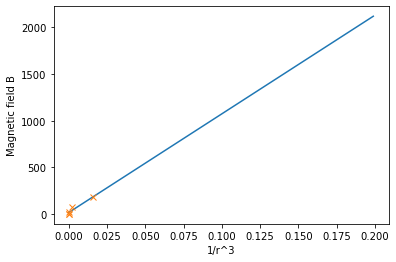

In [10]:
#Now fitting a straight line to the data

def linear_best_fit(x, m, c):
    return (m*x) + c

popt, pcov = curve_fit(linear_best_fit, x_axis_values, B)
print ("Gradient = ", popt[0], "+/-", pcov[0,0]**0.5)
print("The y-intercept = ", popt[1], "+/-", pcov[1,1]**0.5)
gradient=popt[0]
intercept=popt[1]

x_array = np.arange(0, 0.2, 0.001)
plt.plot(x_array, linear_best_fit(x_array, gradient, intercept))
plt.plot(x_axis_values, B, 'x')
plt.xlabel("1/r^3")
plt.ylabel("Magnetic field B")
plt.show()

In [11]:
#Now to calculate the magnetic moment value, taking into account the units of the gradient

m = gradient*10**-12 *((2*np.pi)/mu)
print("the magnetic moment is ", m)

the magnetic moment is  0.052839019044735265


In [12]:
# working out proportionality const

r=55e-3 #distance from mag to coil

const = (3*R**2*mu*m)/(2*r**4)
print("The EMF proportionality constant is ", const)

The EMF proportionality constant is  0.00027863281853796767


In [13]:
#Refitting the data to a EMF fitting curve, using the the SHM solution for v(t) multiplied by the constant found earlier

t = np.arange(0, t_cutoff, 0.0001)

def emf_fit(t, A, b, w_star, phi):
    beta = b/(2*m)
    exponential_term = -A*np.exp(-beta*t)
    sin_term = w_star * np.sin(w_star*t + phi)
    cos_term = beta *np.cos(w_star*t +phi)
    return const*exponential_term*(sin_term + cos_term)

popt, pcov = curve_fit(emf_fit, refined_time, refined_voltage)
print("A =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)
print("w_star =", popt[2], "+/-", pcov[2,2]**0.5)
print("phi =", popt[3], "+/-", pcov[3,3]**0.5)

A = popt[0]
b = popt[1]
w_star = popt[2]
phi = popt[3]
w_star_err = pcov[2,2]**0.5


A = 0.19799924542251265 +/- 0.0012378090517796863
b = 0.4260277573003804 +/- 0.003992158668371827
w_star = -109.06526250595356 +/- 0.039309782233819396
phi = 2.4512044114711284 +/- 0.006753518077106089


[]

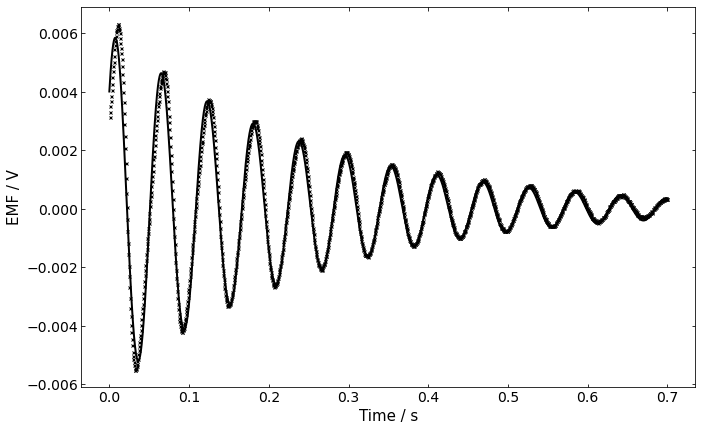

In [14]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
plt.plot(t, emf_fit(t, A, b, w_star, phi), color = "black", linewidth = 2)
plt.plot(refined_time, refined_voltage, marker = 'x', color = 'black', ls = 'none', markersize = 3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time / s", size = 15)
plt.ylabel("EMF / V", size = 15)
plt.tick_params(direction='in',      
                left='on',
                top='on',
                right='on')
plt.plot()

In [15]:
beta = b/(2*m)
w_0 = np.sqrt(w_star**2 + beta**2)
print("The damping constant is " ,beta)
print("The undamped frequency, w_0 is", w_0)

The damping constant is  4.03137458834816
The undamped frequency, w_0 is 109.13974283717246


In [16]:
#So here it is reading in another sheet that i added to the nitrogen excel file.
#I took the 5 volumes used and converted them to m^3 from ml and then took the sqrt of the inverse of the volumes.
#For each volume i used the above code to calculate w_0 for each volume and the converted it to f_0

final_data=pd.read_excel('helium_data.xlsx', sheet_name='analysis')

In [17]:
x_axis=final_data['sqrt(1/v)'] #volumes converted to m^3
y_axis=final_data['f0'] #natural frequency in Hz
print(final_data)

#Printed is basically a mirror image of the extra sheet on the excel file 
#Note that the 20ml data point is missing here as discussed

    sqrt(1/v)        f0
0  133.274114  6.211773
1  122.812688  5.430293
2  114.482138  4.979714
3  107.645183  4.496867
4  101.902973  4.287012
5   96.991431  4.060654


The gradient of the line of best fit is 0.0592


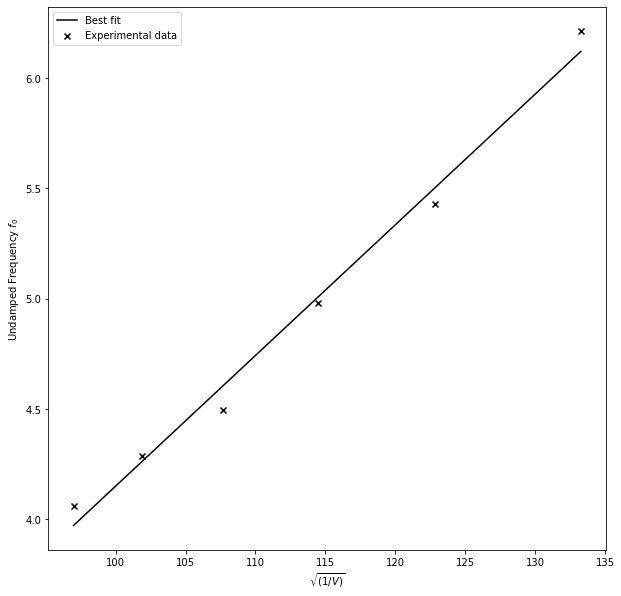

In [18]:
#Here i am defining a function for a linear line of best fit, and then plotting the experimental data with the best fit line

def best_fit(x,m,c):
    return (m*x)+c
plt.figure(figsize=(10,10))
popt, pcov=curve_fit(best_fit, x_axis, y_axis)

plt.scatter(x_axis, y_axis, marker='x', color='black', label='Experimental data')
plt.xlabel('$\sqrt{(1/V)}$')
plt.ylabel('Undamped Frequency $f_0$')
plt.plot(x_axis, best_fit(x_axis, *popt), color='black', label='Best fit')
plt.legend(loc='best')
print('The gradient of the line of best fit is %.4f' %popt[0])
plt.savefig("final plot.png")

In [19]:
#CALCULATING GAMMA
gradient=popt[0]
#pressure=1011*100  #estimate of pressure - obviously this needs to replaced with the actual experimental values given with the new data
diameter=34.16*10**-3
area=math.pi*(diameter/2)**2 #x-sectional area calculated from given diameter
mass=0.10618
pressure = (1011*1*10^5)+((mass*9.81)/area)

In [20]:
gamma=(mass/pressure)*(gradient*2*np.pi/area)**2
print(gamma)

1.5561080028269751
